<a href="https://colab.research.google.com/github/WilliamAshbee/splineexample/blob/main/DatasciencePresentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

x0_y0_r_xrf_yrf torch.Size([100, 1]) torch.Size([100, 1]) torch.Size([100, 1000]) torch.Size([1, 1000]) torch.Size([1, 1000])


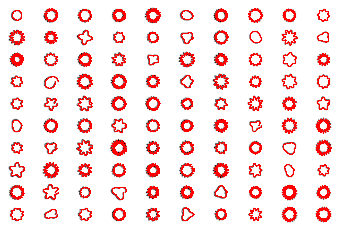

In [1]:
import torch
import numpy as np
import pylab as plt
from skimage import filters
import math

global numpoints
numpoints = 1000
side = 32

rows = torch.zeros(32,32)
columns = torch.zeros(32,32)


for i in range(32):
    columns[:,i] = i
    rows[i,:] = i


def donut_matrix(length = 10):
    radiusMax = side /3
    w = 1
    sigmas = [None, 1]
    
    canvas = torch.zeros((length,side, side))
    r0 = torch.tensor(np.random.uniform(side/4, side/3, length))

    radii = torch.zeros((length,numpoints))
    radii[:, :] = r0.unsqueeze(1)
    
    ind = [x for x in range(numpoints)]

    theta = torch.FloatTensor(ind)
    theta *= math.pi*2.0/(float)(numpoints)
    
    for i in range(1,length):
        a = np.random.uniform(1.0,3.0)*torch.sin(np.random.uniform(20.0)*theta+np.random.uniform(1000.0))
        radii[i,:] += a
    
    assert torch.min(radii)>0
    rmaxs = radii.max(axis = 1)[0]
    pmins = rmaxs+1.0
    pmaxs = side-rmaxs-1.0
    x0 = np.random.uniform(pmins,pmaxs)
    y0 = np.random.uniform(pmins,pmaxs)
    x0[:]=side/2
    y0[:]=side/2
    x0 = torch.tensor(x0)
    y0 = torch.tensor(y0)
    
    x0 = x0.unsqueeze(1)
    y0 = y0.unsqueeze(1)
    xrfactors = torch.cos(theta).unsqueeze(0)
    yrfactors = torch.sin(theta).unsqueeze(0)
    
    print('x0_y0_r_xrf_yrf',x0.shape,y0.shape,radii.shape,xrfactors.shape,yrfactors.shape)

    x = (x0+(xrfactors*radii))
    y = (y0+(yrfactors*radii))
    assert x.shape == (length,numpoints)
    assert y.shape == (length,numpoints)
    assert torch.sum(x[x>(side-1)])==0 
    assert torch.sum(x[x<0])==0 
    assert torch.sum(y[y>(side-1)])==0 
    assert torch.sum(y[y<0])==0 
    
    points = torch.zeros(length,numpoints,2)
    for l in range(length):
        canvas[l,y[l,:].type(torch.LongTensor),x[l,:].type(torch.LongTensor)]=1.0
        points[l,:,0] = x[l,:]#modified for lstm discriminator
        points[l,:,1] = y[l,:]#modified for lstm discriminator 
    
    
    return {
        'canvas': canvas, 
        'points':points.type(torch.FloatTensor)}


def plot_all( sample = None, model = None, labels = None):
    img = sample[:,:].squeeze().cpu().numpy()
    plt.imshow(img, cmap=plt.cm.gray_r)
    if model != None:
        with torch.no_grad():
            global numpoints

            #sample = torch.stack([sample for i in range(64)],dim = 0).cuda()
            pred = model(sample.cuda())#come back to this
            predres = numpoints
            X = pred[0,:,0]
            Y = pred[0,:,1]
            assert X.shape[0] == 1000
            assert Y.shape[0] == 1000
            s = [.001 for x in range(predres)]
            
            assert len(s) == predres
            c = ['red' for x in range(predres)]
            assert len(c) == predres
            Y = Y.cuda()
            X = X.cuda()
            plt.plot(X.cpu(),Y.cpu(),',-',c='red', ms=.1, lw=0.1) 

    else:
        X = labels[:,0]
        Y = labels[:,1]
        s = [.0001 for x in range(numpoints)]
        c = ['red' for x in range(numpoints)]
        plt.plot(X.cpu(),Y.cpu(),',-',c='red',  ms=.1, lw=0.1) 


class DonutDataset(torch.utils.data.Dataset):
    def __init__(self, length = 10):
        self.length = length
        self.values = donut_matrix(length)
        assert self.values['canvas'].shape[0] == self.length
        assert self.values['points'].shape[0] == self.length
        
        count = 0
        for i in range(self.length):
          a = self[i]
          c = a[0]
          for el in a[1]:
            y,x = (int)(el[1]),(int)(el[0])
            if x < side-2 and x > 2 and y < side-2 and y > 2: 
              if c[y,x] != 1 and \
                c[y+1,x] != 1 and c[y+1,-1+x] != 1 and c[y+1,1+x] != 1 and \
                c[y-1,x] != 1 and c[y,-1+x] != 1 and c[y,1+x] != 1:
                count+=1
        assert count ==0


    def __len__(self):
        return self.length


    def __getitem__(self, idx):
        canvas = self.values["canvas"]
        canvas = canvas[idx,:,:]
        assert canvas.shape == (side,side)
        points = self.values["points"]
        points = points[idx,:]
        #z = torch.zeros(numpoints,1)
        #points = torch.cat([points,z], dim = 1)
        
        return canvas, points
    
    @staticmethod
    def displayCanvas(title,dataset, model):
        for i in range(100):
            sample, labels = dataset[i]
            plt.subplot(10,10,i+1)
            plot_all(sample = sample,model=model, labels = labels)
            plt.axis('off')
        plt.savefig(title,dpi=1200)
        
dataset = DonutDataset(length = 100)

DonutDataset.displayCanvas('donut.png',dataset, model = None)


In [2]:
d = dataset

In [3]:
import torch
import torch.nn as nn
from torch.hub import load_state_dict_from_url

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.input_dim = 1*32*32
        self.output_dim = 2000
        self.net = nn.Sequential(
            nn.Linear(self.input_dim, self.input_dim),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(self.input_dim, self.input_dim),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(self.input_dim, self.output_dim),
            nn.Sigmoid()
        )
        
        

    def forward(self, x):
        #x = x.squeeze()
        if x.shape[0]!= mini_batch:
          assert x.shape[0] == 32 and x.shape[1] == 32
          x = x.unsqueeze(0)
        x = torch.flatten(x,start_dim=1)
        
        #assert x.shape == (mini_batch,self.hidden_dim)
        out = self.net(x)
        out = out.reshape(x.shape[0],1000,2)
        return 32.0*out


In [4]:
model = MLP().cuda()

In [5]:
optimizer = torch.optim.Adam(model.parameters(),lr = 0.0001, betas = (.9,.999))

In [6]:
from torch.utils import data
from torch.utils.data import DataLoader, TensorDataset, RandomSampler

mini_batch = 64
dataset = DonutDataset(length=64*20)
loader_train = data.DataLoader(
    dataset, 
    batch_size=mini_batch,
    sampler=RandomSampler(data_source=dataset),
    num_workers=4)


x0_y0_r_xrf_yrf torch.Size([1280, 1]) torch.Size([1280, 1]) torch.Size([1280, 1000]) torch.Size([1, 1000]) torch.Size([1, 1000])


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [7]:
epoch = 40
loss = None
model = model.train()
for e in range(epoch):
  for xin,yin in loader_train:
    optimizer.zero_grad()

    if xin.shape[0] != mini_batch:
      print(xin.shape)
      continue
    xin = xin.cuda()
    yin = yin.cuda()
    out = model(xin)
    assert out.shape == yin.shape
    
    loss = torch.mean((out-yin)**2)
    loss.backward()
    optimizer.step()
    
  print(e,'\t', loss)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


0 	 tensor(17.8858, device='cuda:0', grad_fn=<MeanBackward0>)
1 	 tensor(6.4458, device='cuda:0', grad_fn=<MeanBackward0>)
2 	 tensor(4.7522, device='cuda:0', grad_fn=<MeanBackward0>)
3 	 tensor(3.8971, device='cuda:0', grad_fn=<MeanBackward0>)
4 	 tensor(2.8098, device='cuda:0', grad_fn=<MeanBackward0>)
5 	 tensor(2.3490, device='cuda:0', grad_fn=<MeanBackward0>)
6 	 tensor(2.3197, device='cuda:0', grad_fn=<MeanBackward0>)
7 	 tensor(1.9545, device='cuda:0', grad_fn=<MeanBackward0>)
8 	 tensor(1.9923, device='cuda:0', grad_fn=<MeanBackward0>)
9 	 tensor(1.9285, device='cuda:0', grad_fn=<MeanBackward0>)
10 	 tensor(1.9836, device='cuda:0', grad_fn=<MeanBackward0>)
11 	 tensor(1.8862, device='cuda:0', grad_fn=<MeanBackward0>)
12 	 tensor(1.7369, device='cuda:0', grad_fn=<MeanBackward0>)
13 	 tensor(1.8463, device='cuda:0', grad_fn=<MeanBackward0>)
14 	 tensor(1.5877, device='cuda:0', grad_fn=<MeanBackward0>)
15 	 tensor(1.7049, device='cuda:0', grad_fn=<MeanBackward0>)
16 	 tensor(1.562

In [8]:
optimizer = torch.optim.Adam(model.parameters(),lr = 0.00001, betas = (.9,.999))

In [9]:
epoch = 40
loss = None
model = model.train()
for e in range(epoch):
  for xin,yin in loader_train:
    optimizer.zero_grad()

    if xin.shape[0] != mini_batch:
      print(xin.shape)
      continue
    xin = xin.cuda()
    yin = yin.cuda()
    out = model(xin)
    assert out.shape == yin.shape
    
    loss = torch.mean((out-yin)**2)
    loss.backward()
    optimizer.step()
    
  print(e,'\t', loss)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


0 	 tensor(1.3589, device='cuda:0', grad_fn=<MeanBackward0>)
1 	 tensor(1.2256, device='cuda:0', grad_fn=<MeanBackward0>)
2 	 tensor(1.2106, device='cuda:0', grad_fn=<MeanBackward0>)
3 	 tensor(1.4203, device='cuda:0', grad_fn=<MeanBackward0>)
4 	 tensor(1.3001, device='cuda:0', grad_fn=<MeanBackward0>)
5 	 tensor(1.3765, device='cuda:0', grad_fn=<MeanBackward0>)
6 	 tensor(1.2967, device='cuda:0', grad_fn=<MeanBackward0>)
7 	 tensor(1.3227, device='cuda:0', grad_fn=<MeanBackward0>)
8 	 tensor(1.2875, device='cuda:0', grad_fn=<MeanBackward0>)
9 	 tensor(1.3051, device='cuda:0', grad_fn=<MeanBackward0>)
10 	 tensor(1.2990, device='cuda:0', grad_fn=<MeanBackward0>)
11 	 tensor(1.2163, device='cuda:0', grad_fn=<MeanBackward0>)
12 	 tensor(1.3857, device='cuda:0', grad_fn=<MeanBackward0>)
13 	 tensor(1.2396, device='cuda:0', grad_fn=<MeanBackward0>)
14 	 tensor(1.3628, device='cuda:0', grad_fn=<MeanBackward0>)
15 	 tensor(1.3729, device='cuda:0', grad_fn=<MeanBackward0>)
16 	 tensor(1.2827

In [10]:
from torch.utils import data
from torch.utils.data import DataLoader, TensorDataset, RandomSampler

mini_batch = 64
test_dataset = DonutDataset(length=100)
loader_test = data.DataLoader(
    dataset, 
    batch_size=mini_batch,
    sampler=RandomSampler(data_source=dataset),
    num_workers=4)


x0_y0_r_xrf_yrf torch.Size([100, 1]) torch.Size([100, 1]) torch.Size([100, 1000]) torch.Size([1, 1000]) torch.Size([1, 1000])


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


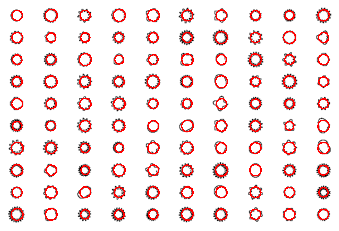

In [11]:
model = model.eval()
DonutDataset.displayCanvas('test3layerConstantWidth.png',test_dataset, model = model)


In [12]:
import torch
import torch.nn as nn
from torch.hub import load_state_dict_from_url

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.input_dim = 1*32*32
        self.output_dim = 2000
        self.net = nn.Sequential(
            nn.Linear(self.input_dim, self.input_dim),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(self.input_dim, self.input_dim),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(self.input_dim, self.input_dim),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(self.input_dim, self.input_dim),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(self.input_dim, self.output_dim),
            nn.Sigmoid()
        )
        
        

    def forward(self, x):
        #x = x.squeeze()
        if x.shape[0]!= mini_batch:
          assert x.shape[0] == 32 and x.shape[1] == 32
          x = x.unsqueeze(0)
        x = torch.flatten(x,start_dim=1)
        
        #assert x.shape == (mini_batch,self.hidden_dim)
        out = self.net(x)
        out = out.reshape(x.shape[0],1000,2)
        return 32.0*out


In [13]:
model = MLP().cuda()
optimizer = torch.optim.Adam(model.parameters(),lr = 0.0001, betas = (.9,.999))


In [14]:
epoch = 40
loss = None
model = model.train()
for e in range(epoch):
  for xin,yin in loader_train:
    optimizer.zero_grad()

    if xin.shape[0] != mini_batch:
      print(xin.shape)
      continue
    xin = xin.cuda()
    yin = yin.cuda()
    out = model(xin)
    assert out.shape == yin.shape
    
    loss = torch.mean((out-yin)**2)
    loss.backward()
    optimizer.step()
    
  print(e,'\t', loss)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


0 	 tensor(14.6831, device='cuda:0', grad_fn=<MeanBackward0>)
1 	 tensor(5.8049, device='cuda:0', grad_fn=<MeanBackward0>)
2 	 tensor(3.7073, device='cuda:0', grad_fn=<MeanBackward0>)
3 	 tensor(2.8616, device='cuda:0', grad_fn=<MeanBackward0>)
4 	 tensor(2.3601, device='cuda:0', grad_fn=<MeanBackward0>)
5 	 tensor(2.1582, device='cuda:0', grad_fn=<MeanBackward0>)
6 	 tensor(2.0926, device='cuda:0', grad_fn=<MeanBackward0>)
7 	 tensor(1.9144, device='cuda:0', grad_fn=<MeanBackward0>)
8 	 tensor(2.0464, device='cuda:0', grad_fn=<MeanBackward0>)
9 	 tensor(1.8632, device='cuda:0', grad_fn=<MeanBackward0>)
10 	 tensor(1.9204, device='cuda:0', grad_fn=<MeanBackward0>)
11 	 tensor(1.8320, device='cuda:0', grad_fn=<MeanBackward0>)
12 	 tensor(1.7885, device='cuda:0', grad_fn=<MeanBackward0>)
13 	 tensor(1.7192, device='cuda:0', grad_fn=<MeanBackward0>)
14 	 tensor(1.6723, device='cuda:0', grad_fn=<MeanBackward0>)
15 	 tensor(1.6856, device='cuda:0', grad_fn=<MeanBackward0>)
16 	 tensor(1.535

In [15]:
optimizer = torch.optim.Adam(model.parameters(),lr = 0.00001, betas = (.9,.999))

In [16]:
epoch = 40
loss = None
model = model.train()
for e in range(epoch):
  for xin,yin in loader_train:
    optimizer.zero_grad()
    if xin.shape[0] != mini_batch:
      print(xin.shape)
      continue
    xin = xin.cuda()
    yin = yin.cuda()
    out = model(xin)
    assert out.shape == yin.shape
    
    loss = torch.mean((out-yin)**2)
    loss.backward()
    optimizer.step()
    
  print(e,'\t', loss)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


0 	 tensor(1.5068, device='cuda:0', grad_fn=<MeanBackward0>)
1 	 tensor(1.3375, device='cuda:0', grad_fn=<MeanBackward0>)
2 	 tensor(1.4608, device='cuda:0', grad_fn=<MeanBackward0>)
3 	 tensor(1.2715, device='cuda:0', grad_fn=<MeanBackward0>)
4 	 tensor(1.3840, device='cuda:0', grad_fn=<MeanBackward0>)
5 	 tensor(1.4332, device='cuda:0', grad_fn=<MeanBackward0>)
6 	 tensor(1.4176, device='cuda:0', grad_fn=<MeanBackward0>)
7 	 tensor(1.3517, device='cuda:0', grad_fn=<MeanBackward0>)
8 	 tensor(1.3505, device='cuda:0', grad_fn=<MeanBackward0>)
9 	 tensor(1.3326, device='cuda:0', grad_fn=<MeanBackward0>)
10 	 tensor(1.3251, device='cuda:0', grad_fn=<MeanBackward0>)
11 	 tensor(1.3222, device='cuda:0', grad_fn=<MeanBackward0>)
12 	 tensor(1.3618, device='cuda:0', grad_fn=<MeanBackward0>)
13 	 tensor(1.2042, device='cuda:0', grad_fn=<MeanBackward0>)
14 	 tensor(1.4036, device='cuda:0', grad_fn=<MeanBackward0>)
15 	 tensor(1.1488, device='cuda:0', grad_fn=<MeanBackward0>)
16 	 tensor(1.4015

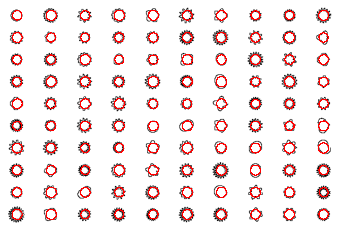

In [17]:
model = model.eval()
DonutDataset.displayCanvas('test6layerConstantWidth.png',test_dataset, model = model)


In [18]:
import torch
import torch.nn as nn
from torch.hub import load_state_dict_from_url

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.input_dim = 1*32*32
        self.output_dim = 2000
        self.net = nn.Sequential(
            nn.Linear(self.input_dim, 10*self.input_dim),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(10*self.input_dim, 10*self.input_dim),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(10*self.input_dim, 10*self.input_dim),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(10*self.input_dim, 10*self.input_dim),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(10*self.input_dim, self.output_dim),
            nn.Sigmoid()
        )
        
        

    def forward(self, x):
        #x = x.squeeze()
        if x.shape[0]!= mini_batch:
          assert x.shape[0] == 32 and x.shape[1] == 32
          x = x.unsqueeze(0)
        x = torch.flatten(x,start_dim=1)
        
        #assert x.shape == (mini_batch,self.hidden_dim)
        out = self.net(x)
        out = out.reshape(x.shape[0],1000,2)
        return 32.0*out


In [19]:
model = MLP().cuda()
optimizer = torch.optim.Adam(model.parameters(),lr = 0.0001, betas = (.9,.999))


In [20]:
epoch = 40
loss = None
model = model.train()
for e in range(epoch):
  for xin,yin in loader_train:
    optimizer.zero_grad()
    if xin.shape[0] != mini_batch:
      print(xin.shape)
      continue
    xin = xin.cuda()
    yin = yin.cuda()
    out = model(xin)
    assert out.shape == yin.shape
    
    loss = torch.mean((out-yin)**2)
    loss.backward()
    optimizer.step()
    
  print(e,'\t', loss)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


0 	 tensor(2.4306, device='cuda:0', grad_fn=<MeanBackward0>)
1 	 tensor(1.5521, device='cuda:0', grad_fn=<MeanBackward0>)
2 	 tensor(1.3651, device='cuda:0', grad_fn=<MeanBackward0>)
3 	 tensor(1.3084, device='cuda:0', grad_fn=<MeanBackward0>)
4 	 tensor(1.2521, device='cuda:0', grad_fn=<MeanBackward0>)
5 	 tensor(1.3160, device='cuda:0', grad_fn=<MeanBackward0>)
6 	 tensor(1.3214, device='cuda:0', grad_fn=<MeanBackward0>)
7 	 tensor(1.3807, device='cuda:0', grad_fn=<MeanBackward0>)
8 	 tensor(1.4557, device='cuda:0', grad_fn=<MeanBackward0>)
9 	 tensor(1.3295, device='cuda:0', grad_fn=<MeanBackward0>)
10 	 tensor(1.2615, device='cuda:0', grad_fn=<MeanBackward0>)
11 	 tensor(1.2799, device='cuda:0', grad_fn=<MeanBackward0>)
12 	 tensor(1.3613, device='cuda:0', grad_fn=<MeanBackward0>)
13 	 tensor(1.4927, device='cuda:0', grad_fn=<MeanBackward0>)
14 	 tensor(1.3762, device='cuda:0', grad_fn=<MeanBackward0>)
15 	 tensor(1.2986, device='cuda:0', grad_fn=<MeanBackward0>)
16 	 tensor(1.2384

In [21]:
optimizer = torch.optim.Adam(model.parameters(),lr = 0.00001, betas = (.9,.999))


In [22]:
epoch = 40
loss = None
model = model.train()
for e in range(epoch):
  for xin,yin in loader_train:
    optimizer.zero_grad()
    if xin.shape[0] != mini_batch:
      print(xin.shape)
      continue
    xin = xin.cuda()
    yin = yin.cuda()
    out = model(xin)
    assert out.shape == yin.shape
    
    loss = torch.mean((out-yin)**2)
    loss.backward()
    optimizer.step()
    
  print(e,'\t', loss)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


0 	 tensor(1.2450, device='cuda:0', grad_fn=<MeanBackward0>)
1 	 tensor(1.2997, device='cuda:0', grad_fn=<MeanBackward0>)
2 	 tensor(1.1014, device='cuda:0', grad_fn=<MeanBackward0>)
3 	 tensor(1.2841, device='cuda:0', grad_fn=<MeanBackward0>)
4 	 tensor(1.1298, device='cuda:0', grad_fn=<MeanBackward0>)
5 	 tensor(1.1823, device='cuda:0', grad_fn=<MeanBackward0>)
6 	 tensor(1.1015, device='cuda:0', grad_fn=<MeanBackward0>)
7 	 tensor(1.1892, device='cuda:0', grad_fn=<MeanBackward0>)
8 	 tensor(1.1827, device='cuda:0', grad_fn=<MeanBackward0>)
9 	 tensor(1.1147, device='cuda:0', grad_fn=<MeanBackward0>)
10 	 tensor(1.1839, device='cuda:0', grad_fn=<MeanBackward0>)
11 	 tensor(1.1489, device='cuda:0', grad_fn=<MeanBackward0>)
12 	 tensor(1.0795, device='cuda:0', grad_fn=<MeanBackward0>)
13 	 tensor(1.0162, device='cuda:0', grad_fn=<MeanBackward0>)
14 	 tensor(1.1018, device='cuda:0', grad_fn=<MeanBackward0>)
15 	 tensor(1.1675, device='cuda:0', grad_fn=<MeanBackward0>)
16 	 tensor(1.2524

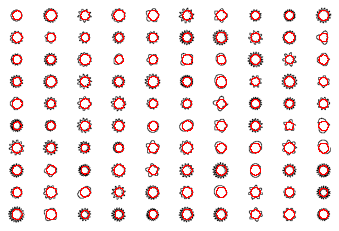

In [23]:
model = model.eval()
DonutDataset.displayCanvas('test6layer10xConstantWidth.png',test_dataset, model = model)


The 6 layer gets slow with 10x units. accuracy also gets worse.  


In [24]:
import torch
import torch.nn as nn
from torch.hub import load_state_dict_from_url

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.input_dim = 1*32*32
        self.output_dim = 2000
        self.net = nn.Sequential(
            nn.Linear(self.input_dim, 10*self.input_dim),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(10*self.input_dim, 10*self.input_dim),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(10*self.input_dim, self.output_dim),
            nn.Sigmoid()
        )
        
        

    def forward(self, x):
        #x = x.squeeze()
        if x.shape[0]!= mini_batch:
          assert x.shape[0] == 32 and x.shape[1] == 32
          x = x.unsqueeze(0)
        x = torch.flatten(x,start_dim=1)
        
        #assert x.shape == (mini_batch,self.hidden_dim)
        out = self.net(x)
        out = out.reshape(x.shape[0],1000,2)
        return 32.0*out


In [25]:
model = MLP().cuda()
optimizer = torch.optim.Adam(model.parameters(),lr = 0.0001, betas = (.9,.999))


In [26]:
epoch = 40
loss = None
model = model.train()
for e in range(epoch):
  for xin,yin in loader_train:
    optimizer.zero_grad()
    if xin.shape[0] != mini_batch:
      print(xin.shape)
      continue
    xin = xin.cuda()
    yin = yin.cuda()
    out = model(xin)
    assert out.shape == yin.shape
    
    loss = torch.mean((out-yin)**2)
    loss.backward()
    optimizer.step()
    
  print(e,'\t', loss)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


0 	 tensor(2.7124, device='cuda:0', grad_fn=<MeanBackward0>)
1 	 tensor(1.7937, device='cuda:0', grad_fn=<MeanBackward0>)
2 	 tensor(1.5018, device='cuda:0', grad_fn=<MeanBackward0>)
3 	 tensor(1.3961, device='cuda:0', grad_fn=<MeanBackward0>)
4 	 tensor(1.2880, device='cuda:0', grad_fn=<MeanBackward0>)
5 	 tensor(1.4155, device='cuda:0', grad_fn=<MeanBackward0>)
6 	 tensor(1.2531, device='cuda:0', grad_fn=<MeanBackward0>)
7 	 tensor(1.2600, device='cuda:0', grad_fn=<MeanBackward0>)
8 	 tensor(1.0881, device='cuda:0', grad_fn=<MeanBackward0>)
9 	 tensor(1.0255, device='cuda:0', grad_fn=<MeanBackward0>)
10 	 tensor(0.9827, device='cuda:0', grad_fn=<MeanBackward0>)
11 	 tensor(0.9636, device='cuda:0', grad_fn=<MeanBackward0>)
12 	 tensor(0.8406, device='cuda:0', grad_fn=<MeanBackward0>)
13 	 tensor(0.7371, device='cuda:0', grad_fn=<MeanBackward0>)
14 	 tensor(0.7750, device='cuda:0', grad_fn=<MeanBackward0>)
15 	 tensor(0.5904, device='cuda:0', grad_fn=<MeanBackward0>)
16 	 tensor(0.5690

In [27]:
optimizer = torch.optim.Adam(model.parameters(),lr = 0.00001, betas = (.9,.999))


In [28]:
epoch = 40
loss = None
model = model.train()
for e in range(epoch):
  for xin,yin in loader_train:
    optimizer.zero_grad()
    if xin.shape[0] != mini_batch:
      print(xin.shape)
      continue
    xin = xin.cuda()
    yin = yin.cuda()
    out = model(xin)
    assert out.shape == yin.shape
    
    loss = torch.mean((out-yin)**2)
    loss.backward()
    optimizer.step()
    
  print(e,'\t', loss)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


0 	 tensor(0.3030, device='cuda:0', grad_fn=<MeanBackward0>)
1 	 tensor(0.2911, device='cuda:0', grad_fn=<MeanBackward0>)
2 	 tensor(0.2973, device='cuda:0', grad_fn=<MeanBackward0>)
3 	 tensor(0.3006, device='cuda:0', grad_fn=<MeanBackward0>)
4 	 tensor(0.2629, device='cuda:0', grad_fn=<MeanBackward0>)
5 	 tensor(0.2639, device='cuda:0', grad_fn=<MeanBackward0>)
6 	 tensor(0.2804, device='cuda:0', grad_fn=<MeanBackward0>)
7 	 tensor(0.2705, device='cuda:0', grad_fn=<MeanBackward0>)
8 	 tensor(0.2501, device='cuda:0', grad_fn=<MeanBackward0>)
9 	 tensor(0.2577, device='cuda:0', grad_fn=<MeanBackward0>)
10 	 tensor(0.2707, device='cuda:0', grad_fn=<MeanBackward0>)
11 	 tensor(0.2357, device='cuda:0', grad_fn=<MeanBackward0>)
12 	 tensor(0.2491, device='cuda:0', grad_fn=<MeanBackward0>)
13 	 tensor(0.2604, device='cuda:0', grad_fn=<MeanBackward0>)
14 	 tensor(0.2437, device='cuda:0', grad_fn=<MeanBackward0>)
15 	 tensor(0.2419, device='cuda:0', grad_fn=<MeanBackward0>)
16 	 tensor(0.2477

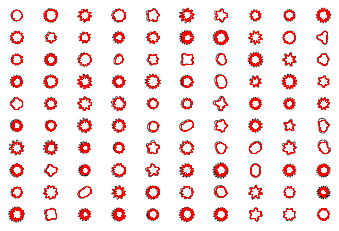

In [29]:
model = model.eval()
DonutDataset.displayCanvas('test3layer10xConstantWidth.png',test_dataset, model = model)


In [30]:
import torch
import torch.nn as nn
from torch.hub import load_state_dict_from_url

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.input_dim = 1*32*32
        self.output_dim = 2000
        self.net = nn.Sequential(
            nn.Linear(self.input_dim, 100*self.input_dim),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(100*self.input_dim, self.output_dim),
            nn.Sigmoid()
        )
        
        

    def forward(self, x):

      #x = x.squeeze()
      if x.shape[0]!= mini_batch:
        assert x.shape[0] == 32 and x.shape[1] == 32
        x = x.unsqueeze(0)
      x = torch.flatten(x,start_dim=1)
      
      #assert x.shape == (mini_batch,self.hidden_dim)
      out = self.net(x)
      out = out.reshape(x.shape[0],1000,2)
      return 32.0*out


In [31]:
model = MLP().cuda()
optimizer = torch.optim.Adam(model.parameters(),lr = 0.0001, betas = (.9,.999))


In [32]:
epoch = 40
loss = None
#model = model.train()
for e in range(epoch):
  for xin,yin in loader_train:
    optimizer.zero_grad()
    if xin.shape[0] != mini_batch:
      print(xin.shape)
      continue
    xin = xin.cuda()
    yin = yin.cuda()
    out = model(xin)
    assert out.shape == yin.shape
    
    loss = torch.mean((out-yin)**2)
    loss.backward()
    optimizer.step()
    
  print(e,'\t', loss)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


0 	 tensor(2.4293, device='cuda:0', grad_fn=<MeanBackward0>)
1 	 tensor(1.2002, device='cuda:0', grad_fn=<MeanBackward0>)
2 	 tensor(0.8062, device='cuda:0', grad_fn=<MeanBackward0>)
3 	 tensor(0.7698, device='cuda:0', grad_fn=<MeanBackward0>)
4 	 tensor(0.4889, device='cuda:0', grad_fn=<MeanBackward0>)
5 	 tensor(0.4018, device='cuda:0', grad_fn=<MeanBackward0>)
6 	 tensor(0.3044, device='cuda:0', grad_fn=<MeanBackward0>)
7 	 tensor(0.2620, device='cuda:0', grad_fn=<MeanBackward0>)
8 	 tensor(0.2438, device='cuda:0', grad_fn=<MeanBackward0>)
9 	 tensor(0.2093, device='cuda:0', grad_fn=<MeanBackward0>)
10 	 tensor(0.1876, device='cuda:0', grad_fn=<MeanBackward0>)
11 	 tensor(0.1841, device='cuda:0', grad_fn=<MeanBackward0>)
12 	 tensor(0.1536, device='cuda:0', grad_fn=<MeanBackward0>)
13 	 tensor(0.1470, device='cuda:0', grad_fn=<MeanBackward0>)
14 	 tensor(0.1445, device='cuda:0', grad_fn=<MeanBackward0>)
15 	 tensor(0.1370, device='cuda:0', grad_fn=<MeanBackward0>)
16 	 tensor(0.1275

In [33]:
optimizer = torch.optim.Adam(model.parameters(),lr = 0.00001, betas = (.9,.999))


In [34]:
epoch = 40
loss = None
#model = model.train()
for e in range(epoch):
  for xin,yin in loader_train:
    optimizer.zero_grad()
    if xin.shape[0] != mini_batch:
      print(xin.shape)
      continue
    xin = xin.cuda()
    yin = yin.cuda()
    out = model(xin)
    assert out.shape == yin.shape
    
    loss = torch.mean((out-yin)**2)
    loss.backward()
    optimizer.step()
    
  print(e,'\t', loss)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


0 	 tensor(0.0693, device='cuda:0', grad_fn=<MeanBackward0>)
1 	 tensor(0.0662, device='cuda:0', grad_fn=<MeanBackward0>)
2 	 tensor(0.0667, device='cuda:0', grad_fn=<MeanBackward0>)
3 	 tensor(0.0647, device='cuda:0', grad_fn=<MeanBackward0>)
4 	 tensor(0.0642, device='cuda:0', grad_fn=<MeanBackward0>)
5 	 tensor(0.0623, device='cuda:0', grad_fn=<MeanBackward0>)
6 	 tensor(0.0612, device='cuda:0', grad_fn=<MeanBackward0>)
7 	 tensor(0.0612, device='cuda:0', grad_fn=<MeanBackward0>)
8 	 tensor(0.0603, device='cuda:0', grad_fn=<MeanBackward0>)
9 	 tensor(0.0595, device='cuda:0', grad_fn=<MeanBackward0>)
10 	 tensor(0.0603, device='cuda:0', grad_fn=<MeanBackward0>)
11 	 tensor(0.0582, device='cuda:0', grad_fn=<MeanBackward0>)
12 	 tensor(0.0577, device='cuda:0', grad_fn=<MeanBackward0>)
13 	 tensor(0.0572, device='cuda:0', grad_fn=<MeanBackward0>)
14 	 tensor(0.0542, device='cuda:0', grad_fn=<MeanBackward0>)
15 	 tensor(0.0537, device='cuda:0', grad_fn=<MeanBackward0>)
16 	 tensor(0.0535

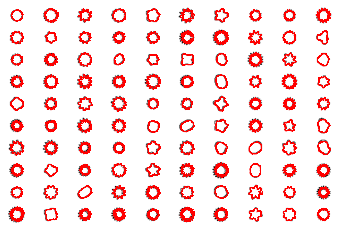

In [35]:
DonutDataset.displayCanvas('test2layer100x.png',test_dataset, model = model)
